Lorsque les ressources computationnelles ne permettent pas de résoudre un SVM ou une régression
logistique, il est utile d’avoir des modèles plus simple à apprendre. C’est le cas du modèle naïf de Bayes qui est quelquefois très efficace. (Contrairement à ce que dit la page wikipédia en français, il ne s’agit pas d’une méthode bayésienne).

— http://en.wikipedia.org/wiki/Naive_Bayes_classifier

— Naive Bayes : A. McCallum and K. Nigam. A comparison of event models for Naive Bayes text classification. In AAAI-98 Workshop on Learning for Text Categorization, 1998.
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.9324&rep=rep1&type=pdf

— Book Chapter : Naive Bayes text classification, Introduction to Information Retrieval
http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html

# 1 base (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/)
``Data base 1 : SMS`` Almeida, T.A., Gamez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.

In [1]:
import re
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

from collections import Counter

In [40]:
def PreprocessSentence (s):
    # Cut and make some preprocessing with input sentence
    words = re.split(r'\W+', re.sub(r'\d+', '', str.lower(s)))  #''
    del words[-1]
    return words

def LoadData (fileName = "data_spam/SMSSpamCollection.txt"):
    # Read data from text file and makes simple preprocessing: 
    #   to lower case -> replace all digit strings with 1 -> split with punctuation and blank characters
    df = pd.DataFrame()
    with open (fileName ,"r") as f :
        f . readline()
        for line in f:
            data = line.split('\t') # num=2)
            df = df.append([[data[0],PreprocessSentence(data[1])]], ignore_index = True) 
    
    df.columns=['lab', 'data']
    return df

def CreateDataSet (dataSet, proportions = np.array([0.6, 0.2, 0.2])):
    # Creates a list with indices of train, validation and test sets  
    proportions_new = proportions/np.sum(proportions)
    
    hamIdx = dataSet[dataSet.lab =='ham'].index 
    nham = len(hamIdx)  
    spamIdx = dataSet[dataSet.lab =='spam'].index 
    nspam = len(spamIdx)
    hamTrainIdx = np.random.choice(hamIdx, math.floor(proportions_new[0]*nham), replace=False)
    hamIdx = np.setdiff1d(hamIdx, hamTrainIdx, assume_unique=False)
    spamTrainIdx = np.random.choice(spamIdx, math.floor(proportions_new[0]*nspam), replace=False)
    spamIdx = np.setdiff1d(spamIdx, spamTrainIdx)
    hamValidationIdx = np.random.choice(hamIdx, math.floor(proportions_new[1]*nham), replace=False)
    hamIdx = np.setdiff1d(hamIdx, hamValidationIdx)
    spamValidationIdx = np.random.choice(spamIdx, math.floor(proportions_new[1]*nspam), replace=False)
    spamIdx = np.setdiff1d(spamIdx, spamValidationIdx)  
    
    # train, validation and test sets
    train = np.random.permutation(np.union1d(hamTrainIdx, spamTrainIdx))
    validation = np.random.permutation(np.union1d(hamValidationIdx, spamValidationIdx))
    test = np.random.permutation(np.union1d(hamIdx, spamIdx))

    ds =  dict()
    ds['train'] = train
    ds['validation'] = validation
    ds['test'] = test
    
    return ds #train, validation, test

In [3]:
def CreateModel(data, laplaceFactor = 0):
    # creates naive bayes spam classifier based on data
    #  INPUT:    train data frame with lab and data fields;laplace factor
    #  OUTPUT:   trained naive bayes model
    
    m = dict(laplaceFactor = laplaceFactor)
    m['total'] = len(data.lab)
    
    m['ham'] = dict()
    m['spam'] = dict()
    
    m['hamLabelCount'] = len(data[data.lab =='ham'])
    m['spamLabelCount'] = len(data[data.lab =='spam'])
    m['hamWordCount'] = 0
    m['spamWordCount'] = 0
    
    uniqueWordSet = set()
    
    for i in range(len(data.lab)):
        sentence = data.data[i] # ?? unlist(data$data[i])
        uniqueWordSet.update(sentence)
        
        for j in range(len(sentence)):            
            if(data.lab[i] == 'ham'):
                if m['ham'].get(sentence[j]) is None:
                    m['ham'][sentence[j]] = 1
                else : 
                    m['ham'][sentence[j]] = m['ham'][sentence[j]] + 1
            
                m['hamWordCount'] = m['hamWordCount'] + 1
            
            else:
                if(data.lab[i] == 'spam'):
                    if m['spam'].get(sentence[j]) is None:
                        m['spam'][sentence[j]] = 1
                    else : 
                        m['spam'][sentence[j]] = m['spam'][sentence[j]] + 1

                m['spamWordCount'] = m['spamWordCount'] + 1
    
    m['uniqueWordCount'] = len(uniqueWordSet)
    
    return(m) 

In [4]:
def GetCount(w, ls) :
    if ls.get(w) is None:
        return 0
    return ls.get(w)
    
def ClassifySentense(s, model, preprocess = True):
    # calculate class of the input sentence based on the model
    #  INPUT:    string sentence, model from CreateModel and
    #            bool flag, if sentence should be preprocessed 
    #  OUTPUT:   class of message HAM or SPAM
    
    words = s
    if(preprocess):
        words = PreprocessSentence(s)

    ham = math.log(model['hamLabelCount']/(model['hamLabelCount'] + model['spamLabelCount']))
    spam = math.log(model['spamLabelCount']/(model['hamLabelCount'] + model['spamLabelCount']))
    for i in range(len(words)):
        ham = ham + math.log((GetCount(words[i], model['ham']) + model['laplaceFactor']) /
                             (model['hamWordCount'] + model['laplaceFactor']*model['uniqueWordCount']))
        spam = spam + math.log((GetCount(words[i], model['spam']) + model['laplaceFactor']) /
                               (model['spamWordCount'] + model['laplaceFactor']*model['uniqueWordCount']))
    if(ham >= spam):
         return ('ham')
    
    return ('spam')

def TestModel (data, model):
    # calculate percentage of errors
    #  INPUT:    data for testing and model
    #  OUTPUT:   percentage of mistakes
    errors = 0
    for i in range(len(data.lab)):
        predictedLabel = ClassifySentense(data.data[i], model, preprocess = False)
        if (predictedLabel != data.lab[i]):
            errors = errors + 1
    return (errors/len(data.lab))

def CrossValidation(trainData, validationData, laplaceFactorValues, showLog = False):
    # Crossvalidation, search best Laplace factrom from given vector
    #  INPUT:    train data, validation data, vector of possible 
    #            factor values, and flag, if log should be shown
    #  OUTPUT:   vector of percentage of errors for corresponding Laplace
    #            factor values
    cvErrors = np.full(len(laplaceFactorValues), None)
    
    for i in range(len(laplaceFactorValues)):
        model = CreateModel(trainData, laplaceFactor = laplaceFactorValues[i])
        cvErrors[i] = TestModel(validationData, model)
        if(showLog):
            print("For laplaceFactorValues = ", laplaceFactorValues[i], 
                  " : error is ", cvErrors[i], "\n")
    return cvErrors

In [62]:
df = LoadData()

In [63]:
ds = CreateDataSet(df, proportions = np.array([0.6, 0.2, 0.2]))
laplaceFactorValues = np.arange(1,11)

DF_train = df.loc[ds['train']].reset_index().drop(['index'], axis='columns')
DF_test = df.loc[ds['test']].reset_index().drop(['index'], axis='columns')
DF_valid = df.loc[ds['validation']].reset_index().drop(['index'], axis='columns')

In [64]:
cvErrors = CrossValidation(DF_train, DF_valid, laplaceFactorValues, showLog = True)

For laplaceFactorValues =  1  : error is  0.025134649910233394 

For laplaceFactorValues =  2  : error is  0.02333931777378815 

For laplaceFactorValues =  3  : error is  0.03231597845601436 

For laplaceFactorValues =  4  : error is  0.03411131059245961 

For laplaceFactorValues =  5  : error is  0.03680430879712747 

For laplaceFactorValues =  6  : error is  0.03949730700179533 

For laplaceFactorValues =  7  : error is  0.04129263913824058 

For laplaceFactorValues =  8  : error is  0.04488330341113106 

For laplaceFactorValues =  9  : error is  0.0466786355475763 

For laplaceFactorValues =  10  : error is  0.04757630161579892 



In [65]:
bestLaplaceFactor = laplaceFactorValues[np.argmin(cvErrors)] #2
print(bestLaplaceFactor)
model = CreateModel(data=DF_train, laplaceFactor=bestLaplaceFactor)
testResult = TestModel(DF_test, model)

result_our = []
for i in range(len(DF_test['data'])):
    result_our.append(ClassifySentense(DF_test['data'][i], model, preprocess = False))
    
result_our = np.array(result_our)

2


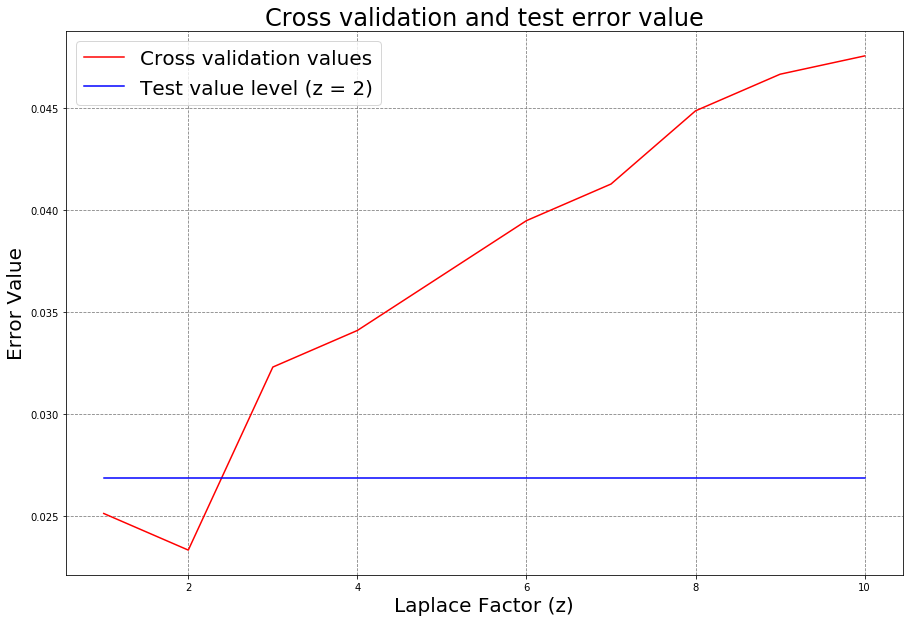

In [122]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(111)
ax1.plot(np.arange(1, len(cvErrors)+1), cvErrors, c='red', label='Cross validation values')
ax1.plot(np.arange(1, len(cvErrors)+1), np.full(len(cvErrors), testResult), 
         c='blue', label='Test value level (z = {})'.format(bestLaplaceFactor))
ax1.set_title('Cross validation and test error value', fontsize = 24)
ax1.legend(fontsize = 20)
ax1.grid(color='gray', linestyle='dashed')
plt.xlabel('Laplace Factor (z)', fontsize = 20)
plt.ylabel('Error Value', fontsize = 20) 
plt.savefig('cros_val.png')
plt.show()

In [67]:
from collections import Counter
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [68]:
# creating word dictionary
def make_Dictionary(data):
    all_words = []   
    for i in range(len(data)):
        words = data[i]
        all_words += words
        
    dictionary = Counter(all_words)
    
    '''list_to_remove = list(dictionary)
            
    for item in list_to_remove:
        if item.isalpha() == False: 
            del dictionary[item]
        elif len(item) == 1:
            del dictionary[item]'''
    
    #dictionary = dictionary.most_common(3000)
    return dictionary
 
#feature extraction process
def extract_features(data, dictionary): 
    features_matrix = np.zeros((len(data),len(dictionary)))
    for i in range(len(data)):
        words = data[i]
        for word in words:
                wordID = 0
                for j,d in enumerate(dictionary):
                    if d == word:
                        wordID = j
                        features_matrix[i,wordID] = words.count(word)
    
    return features_matrix

In [69]:
dictionary = make_Dictionary(np.array(DF_train['data']))
train_matrix = extract_features(np.array(DF_train['data']), dictionary)
train_labels = np.array(DF_train['lab'])

In [70]:
# Training LDA, SVM and Naive bayes classifier
model1 = MultinomialNB()
model2 = LinearSVC()
model3 = LinearDiscriminantAnalysis()
model4 = QuadraticDiscriminantAnalysis()
model5 = KNeighborsClassifier()

model1.fit(train_matrix,train_labels)
model2.fit(train_matrix,train_labels)
model3.fit(train_matrix,train_labels)
model4.fit(train_matrix,train_labels)
model5.fit(train_matrix,train_labels)

C:\Users\13_Vi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\13_Vi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [71]:
# Test the unseen mails for Spam
test_matrix = extract_features(np.array(DF_test['data']), dictionary)
test_labels = np.array(DF_test['lab'])

result1 = model1.predict(test_matrix)
result2 = model2.predict(test_matrix)
result3 = model3.predict(test_matrix)
result4 = model4.predict(test_matrix)
result5 = model5.predict(test_matrix)

In [72]:
print ('Confusion matrix :\n')

print('\nFor our NB : \n', confusion_matrix(test_labels,result_our))
print ('\nFor MultinomialNB : \n', confusion_matrix(test_labels,result1))
print ('\nFor LinearSVC : \n', confusion_matrix(test_labels,result2))
print ('\nFor LDA : \n', confusion_matrix(test_labels,result3))
print ('\nFor QDA : \n', confusion_matrix(test_labels,result4))
print ('\nFor KNN : \n', confusion_matrix(test_labels,result5))

Confusion matrix :


For our NB : 
 [[949  17]
 [ 13 137]]

For MultinomialNB : 
 [[961   5]
 [ 15 135]]

For LinearSVC : 
 [[961   5]
 [ 19 131]]

For LDA : 
 [[822 144]
 [ 38 112]]

For QDA : 
 [[943  23]
 [ 73  77]]

For KNN : 
 [[965   1]
 [ 93  57]]


###### Exemples :
First message is a HAM, second is a SPAM :

In [73]:
phrase_1 = 'As per your request "Melle Melle (Oru Minnaminunginte Nurungu Vettam)" has been set as your callertune for all Callers. Press *9 to copy your friends Callertune'
phrase_2 = 'URGENT! We are trying to contact U.Todays draw shows that you have won a 2000 prize GUARANTEED. Call 090 5809 4507 from land line. Claim 3030. Valid 12hrs only'

``Our method`` :

In [74]:
print(ClassifySentense(phrase_1, model))
print(ClassifySentense(phrase_2, model))

ham
spam


``Others`` :

In [75]:
exempl_matrix_1 = extract_features([phrase_1], dictionary)

In [76]:
print(model1.predict(exempl_matrix_1))
print(model2.predict(exempl_matrix_1))
print(model3.predict(exempl_matrix_1))
print(model4.predict(exempl_matrix_1))
print(model5.predict(exempl_matrix_1))

['ham']
['ham']
['ham']
['ham']


In [77]:
exempl_matrix_2 = extract_features([phrase_2], dictionary)

In [79]:
print(model1.predict(exempl_matrix_2))
print(model2.predict(exempl_matrix_2))
print(model3.predict(exempl_matrix_2))
print(model4.predict(exempl_matrix_2))
print(model5.predict(exempl_matrix_2))

['ham']
['ham']
['ham']
['ham']
['ham']


In [80]:
def print_FN_sentence (y_pred, y_true, data_base):
    print('False-Negative sentences :')
    k = 1
    for i in range (len(y_pred)):
        if (y_true[i] == 'ham') and (y_pred[i] == 'spam'):
            print ('\n', k, ': \t' ,' '.join(str(e) for e in data_base['data'][i]), '\n')
            k+=1
            
def print_FP_sentence (y_pred, y_true, data_base):
    print('False-Positive sentences :')
    k = 1
    for i in range (len(y_pred)):
        if (y_true[i] == 'spam') and (y_pred[i] == 'ham'):
            print ('\n', k, ': \t' ,' '.join(str(e) for e in data_base['data'][i]), '\n')
            k+=1

In [81]:
print_FN_sentence (result_our, test_labels, DF_test)

False-Negative sentences :

 1 : 	 nan sonathaya soladha why boss 


 2 : 	 yalru lyfu astne chikku bt innu mundhe lyf ali halla ke bilo marriage program edhae so lyf is nt yet ovr chikku ali vargu lyfu meow meow d 


 3 : 	 ultimately tor motive tui achieve korli 


 4 : 	 we have sent jd for customer service cum accounts executive to ur mail id for details contact us 


 5 : 	 i career tel have added u as a contact on indyarocks com to send free sms to remove from phonebook sms no to lt gt 


 6 : 	 miss call miss call khelate kintu opponenter miss call dhorte lage thats d rule one with great phone receiving quality wins 


 7 : 	  si como no listenedthe plaid album quite gd the new air which is hilarious also boughtâ braindanceâ a comp ofstuff on aphexâ s abel u havhear it c u sn xxxx 


 8 : 	  gran onlyfound out afew days ago cusoon honi 


 9 : 	 im in inperialmusic listeningthe weirdest track ever byâ leafcutter johnâ sounds like insects being molested someone plumbing remixed b

In [82]:
print_FP_sentence (result_our, test_labels, DF_test)

False-Positive sentences :

 1 : 	 freemsg hey i m buffy and love to satisfy men home alone feeling randy reply c my pix qlynnbv helpp a msg send stop to stop txts 


 2 : 	 tbs persolvo been chasing us since sept forâ definitely not paying now thanks to your information we will ignore them kath manchester 


 3 : 	 hi its lucy hubby at meetins all day fri i will b alone at hotel u fancy cumin over pls leave msg day lucy x callsâ minmobsmorelkpoboxhpfl 


 4 : 	 freemsg hey there darling it s been week s now and no word back i d like some fun you up for it still tb ok xxx std chgs to send â to rcv 


 5 : 	 did you hear about the new divorce barbie it comes with all of ken s stuff 


 6 : 	 you won t believe it but it s true it s incredible txts reply g now to learn truly amazing things that will blow your mind from ofwd only p txt 


 7 : 	 freemsg hey u i just got of these video pic fones reply wild to this txt ill send u my pics hurry up im so bored at work xxx p rcvd stopstop 


 8

# 2 base (https://www.dropbox.com/s/yjiplngoa430rid/)

``Data base 1 : emails`` Ion Androutsopoulos, John Koutsias, Konstantinos V. Chandrinos, George Paliouras
and Constantine D. Spyropoulos 'An Evaluation of Naive Bayesian Anti-Spam Filtering' 2000

In [83]:
train_dir = 'train-mails'
test_dir = 'test-mails'

In [86]:
def LoadData_emails (fileName, tag = 'train'):
    # Read data from text file and makes simple preprocessing: 
    #   to lower case -> replace all digit strings with 1 -> split with punctuation and blank characters
    df = pd.DataFrame()
    
    if tag == 'train':
        K = 351
    else : 
        if tag == 'test':
            K = 130
        else : 
            print('ERROR')
            return 0
    
    
    emails = [os.path.join(fileName,f) for f in os.listdir(fileName)]  
    k = 0
    for mail in emails:    
        with open(mail,"r") as m:
            if (k<K):
                df = df.append([['ham',PreprocessSentence(m.read())]], ignore_index = True) 
            else :
                df = df.append([['spam',PreprocessSentence(m.read())]], ignore_index = True) 
        k+=1
    
    df.columns=['lab', 'data']
    return df

In [87]:
df_emails = LoadData_emails(train_dir)
df_emails_test = LoadData_emails(test_dir, 'test')

In [102]:
#frame_mails = df_emails1.append(df_emails).reset_index()
ds_emails = CreateDataSet(df_emails, proportions = np.array([0.7, 0.3, 0.0]))
laplaceFactorValues_emails = np.arange(1,11)

In [103]:
DF_train_emails = df_emails .loc[ds_emails['train']].reset_index().drop(['index'], axis='columns')
DF_valid_emails = df_emails .loc[ds_emails['validation']].reset_index().drop(['index'], axis='columns')

DF_test_emails = df_emails_test.sample(frac=1).reset_index(drop=True)

cvErrors_emails = CrossValidation(DF_train_emails, DF_valid_emails, laplaceFactorValues_emails, showLog = True)

For laplaceFactorValues =  1  : error is  0.01904761904761905 

For laplaceFactorValues =  2  : error is  0.023809523809523808 

For laplaceFactorValues =  3  : error is  0.023809523809523808 

For laplaceFactorValues =  4  : error is  0.02857142857142857 

For laplaceFactorValues =  5  : error is  0.02857142857142857 

For laplaceFactorValues =  6  : error is  0.02857142857142857 

For laplaceFactorValues =  7  : error is  0.0380952380952381 

For laplaceFactorValues =  8  : error is  0.04285714285714286 

For laplaceFactorValues =  9  : error is  0.04285714285714286 

For laplaceFactorValues =  10  : error is  0.04285714285714286 



1


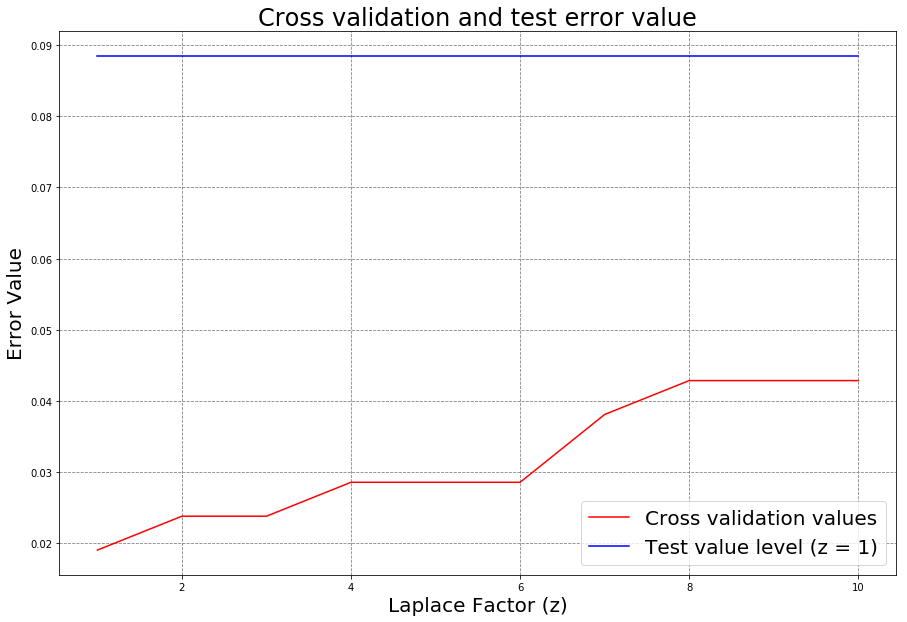

In [104]:
bestLaplaceFactor_emails = laplaceFactorValues_emails[np.argmin(cvErrors_emails)] #2
print(bestLaplaceFactor_emails)
model_emails = CreateModel(data=DF_train_emails, laplaceFactor=bestLaplaceFactor_emails)
testResult_emails = TestModel(DF_test_emails, model_emails)

result_our_emails = []
for i in range(len(DF_test_emails['data'])):
    result_our_emails.append(ClassifySentense(DF_test_emails['data'][i], model_emails, preprocess = False))
    
result_our_emails = np.array(result_our_emails)

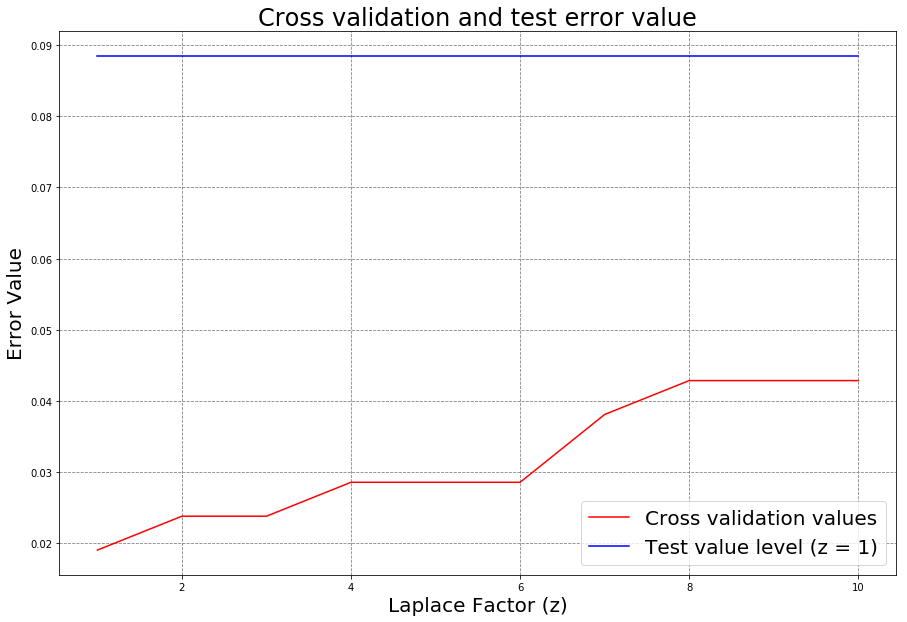

In [123]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(111)
ax1.plot(np.arange(1, len(cvErrors_emails)+1), cvErrors_emails, c='red', label='Cross validation values')
ax1.plot(np.arange(1, len(cvErrors_emails)+1), np.full(len(cvErrors_emails), testResult_emails), 
         c='blue', label='Test value level (z = {})'.format(bestLaplaceFactor_emails))
ax1.set_title('Cross validation and test error value', fontsize = 24)
ax1.legend(fontsize = 20)
ax1.grid(color='gray', linestyle='dashed')
plt.xlabel('Laplace Factor (z)', fontsize = 20)
plt.ylabel('Error Value', fontsize = 20) 
plt.savefig('cros_val_emails.png')
plt.show()

In [105]:
dictionary_emails  = make_Dictionary(np.array(DF_train_emails['data']))
train_matrix_emails  = extract_features(np.array(DF_train_emails['data']), dictionary_emails)
train_labels_emails  = np.array(DF_train_emails['lab'])

In [108]:
# Training LDA, SVM and Naive bayes classifier
model1_emails  = MultinomialNB()
model2_emails  = LinearSVC()
model3_emails  = LinearDiscriminantAnalysis()
model4_emails  = QuadraticDiscriminantAnalysis()
model5_emails  = KNeighborsClassifier()

model1_emails .fit(train_matrix_emails ,train_labels_emails )
model2_emails .fit(train_matrix_emails ,train_labels_emails )
model3_emails .fit(train_matrix_emails ,train_labels_emails )
model4_emails .fit(train_matrix_emails ,train_labels_emails )
model5_emails .fit(train_matrix_emails ,train_labels_emails )

C:\Users\13_Vi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\13_Vi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [112]:
test_matrix_emails = extract_features(np.array(DF_test_emails['data']), dictionary_emails)
test_labels_emails = np.array(DF_test_emails['lab'])

In [115]:
result1_emails = model1_emails.predict(test_matrix_emails)
result2_emails = model2_emails.predict(test_matrix_emails)
result3_emails = model3_emails.predict(test_matrix_emails)
result4_emails = model4_emails.predict(test_matrix_emails)
result5_emails = model5_emails.predict(test_matrix_emails)

In [116]:
print ('Confusion matrix :\n')

print('\nFor our NB : \n', confusion_matrix(test_labels_emails,result_our_emails))
print ('\nFor MultinomialNB : \n', confusion_matrix(test_labels_emails,result1_emails))
print ('\nFor LinearSVC : \n', confusion_matrix(test_labels_emails,result2_emails))
print ('\nFor LDA : \n', confusion_matrix(test_labels_emails,result3_emails))
print ('\nFor QDA : \n', confusion_matrix(test_labels_emails,result4_emails))
print ('\nFor KNN : \n', confusion_matrix(test_labels_emails,result5_emails))


Confusion matrix :


For our NB : 
 [[116  14]
 [  9 121]]

For MultinomialNB : 
 [[115  15]
 [  9 121]]

For LinearSVC : 
 [[118  12]
 [  3 127]]

For LDA : 
 [[113  17]
 [ 63  67]]

For QDA : 
 [[99 31]
 [89 41]]

For KNN : 
 [[ 71  59]
 [  2 128]]


In [117]:
print_FN_sentence (result_our_emails, test_labels_emails, DF_test_emails)

False-Negative sentences :

 1 : 	 subject whole part whole part w p bolzano maretsch castle june presentation science connect complementarity analysis synthesis classical physics characterize in built analysis world constituent part atom elementary particle recompose together provide means synthesis system interaction linearly locally describe result hierarchy structure ground constituent part contemporary science age pure analysis seem end deep mathematical reason non linear system property general cannot express term decomposition ultimate unstructure pointlike part plus suitable set relation among moreover dialectic quantity quality subtler previously dialectic need explanation sort phenomenon arise physics study cognitive system natural program language within psychology gestalten cohesive whole whole sum part mean exactly similar question emerge context relevant foundation science need clear understand part whole relationship emerge even logic mathematics since provide tool organ

In [118]:
print_FP_sentence (result_our_emails, test_labels_emails, DF_test_emails)

False-Positive sentences :

 1 : 	 subject hello university degree programs increase personal prestige money earn power through advance university degree eminent non accredit university award degree degree grant base present knowledge experience further effort necessary part short phone call require ba ma mba phd diploma field choice detail call 


 2 : 	 subject hello university degree programs increase personal prestige money earn power through advance university degree eminent non accredit university award degree degree grant base present knowledge experience further effort necessary part short phone call require ba ma mba phd diploma field choice detail call 


 3 : 	 subject view hollander collection view hollander collection t h e h o l l n d e r c o l l e c t o n f v e r t s t s o n e f m l y gino hollander paint jim hollander photography sirus hollander sculpture view http www hollanderart com scott hollander photography barbara hollander write 


 4 : 	 subject here university

### Overfitting ?

In [119]:
result_our_emails = []
for i in range(len(DF_train_emails['data'])):
    result_our_emails.append(ClassifySentense(DF_train_emails['data'][i], model_emails, preprocess = False))
    
result_our_emails = np.array(result_our_emails)

result1_emails = model1_emails.predict(train_matrix_emails)
result2_emails = model2_emails.predict(train_matrix_emails)
result3_emails = model3_emails.predict(train_matrix_emails)
result4_emails = model4_emails.predict(train_matrix_emails)
result5_emails = model5_emails.predict(train_matrix_emails)

In [121]:
print ('Confusion matrix train:\n')

print('\nFor our NB : \n', confusion_matrix(train_labels_emails,result_our_emails))
print ('\nFor MultinomialNB : \n', confusion_matrix(train_labels_emails,result1_emails))
print ('\nFor LinearSVC : \n', confusion_matrix(train_labels_emails,result2_emails))
print ('\nFor LDA : \n', confusion_matrix(train_labels_emails,result3_emails))
print ('\nFor QDA : \n', confusion_matrix(train_labels_emails,result4_emails))
print ('\nFor KNN : \n', confusion_matrix(train_labels_emails,result5_emails))

Confusion matrix train:


For our NB : 
 [[245   0]
 [  3 242]]

For MultinomialNB : 
 [[245   0]
 [  3 242]]

For LinearSVC : 
 [[245   0]
 [  0 245]]

For LDA : 
 [[245   0]
 [  1 244]]

For QDA : 
 [[245   0]
 [  0 245]]

For KNN : 
 [[125 120]
 [  4 241]]
